In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from PIL import Image
import yaml
from utils import *
from helpers import *

import pdb
from tqdm import tqdm

from proSVD import proSVD
from dlclive import DLCLive, Processor

In [129]:
config_file = "octo"
with open(f'configs/{config_file}.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
IS_METADATA_PRESENT = (config['path']['xls'] is not None)
files_info = None
filenames = None

fps = config['info']['fps']

root_dir = config['path']['root']
video_dir = f"{root_dir}/{config['path']['video']}"

if IS_METADATA_PRESENT:
    xls_path = f"{root_dir}/{config['path']['xls']}"
    files_info = read_octopus_xlsx(xls_path)
    files_info = files_info[files_info['Stim Method'] == 'Electrical']
    filenames = files_info["File Name"].to_list()
else:
    filenames = [os.path.splitext(file)[0] for file in os.listdir(video_dir)]

###

working_dir = f"{root_dir}/{config['path']['working']}" # to save processed data and figures

model_path = f"{root_dir}/{config['path']['model']}"

dlc_live = DLCLive(
    model_path,
    processor=Processor(),
    pcutoff=0.2,
    resize=1)

PROSVD_K = 4 # no. of dims to reduce to

TIME_MARGIN = (-120, 180) # to trim videos
total_f = TIME_MARGIN[1] - TIME_MARGIN[0]

init_frame_crop = 10 # No of initial frames used to set cropping info
init_frame_prosvd = 90 # No of initial frames used to initialize proSVD
init_frame = init_frame_crop + init_frame_prosvd


DEV_MODE = False
if DEV_MODE:
    files_info = files_info.iloc[[0,3,13,14,15,16]] #[3:4]
    filenames = files_info["File Name"].to_list()

print(f"Processing {len(filenames)} videos from {video_dir}")
if len(filenames) < 4:
    print('\t', end='')
    print(*filenames, sep="\n\t")

Processing 56 videos from /home/sachinks/Code/MyProjects/OctopusVideos/videos


In [130]:
def get_fig_dir(filename):
    figs_dir = f"{working_dir}/figs"
    os.makedirs(figs_dir, exist_ok=True)
    return figs_dir

def get_data_dir(filename):
    data_dir = f"{working_dir}/data/{filename}"
    os.makedirs(data_dir, exist_ok=True)
    return data_dir

def is_badpose(likely, threshold=0.8):
    return np.mean(likely) < threshold

def calculate_nancount(data):
    nan_count = np.sum(np.isnan(data))
    return 100*nan_count/data.size

class DataManager:
    def __init__(self):
        self.data = {
            'Q': []
        }
    
    def _print_key_error(self, key):
        print(f"Key '{key}' does not exist in the data manager.")

    def add_nan(self, key, shape):
        data_ = self.data[key]
        pop_count = 0
        while len(data_) > 0 and data_[-1] is None:
            data_.pop()
            pop_count += 1
        while pop_count > 0:
            data_.append(np.full(shape, np.nan))
            pop_count -= 1

    def add(self, key, value):
        if key in self.data:
            if value is not None:
                self.add_nan(key, value.shape)
            self.data[key].append(value)
        else:
            self._print_key_error(key)

    def to_numpy(self):
        for key in self.data:
            data_ = self.data[key]
            if len(data_) == 0 or data_[0] is None:
                self.data[key] = None
                return
            self.add_nan(key, data_[0].shape)
            self.data[key] = np.array(data_)

    def remove(self, key):
        if key in self.data:
            del self.data[key]
        else:
            self._print_key_error(key)

    def get(self, key):
        if key in self.data:
            return self.data[key]
        else:
            self._print_key_error(key)
            return None

In [8]:
# poses = None

for video_idx in tqdm(range(len(filenames))):
    row = files_info.iloc[video_idx]
    md = load_metadata_new(row, time_margin = TIME_MARGIN)

    start_f, end_f = md[0], md[1]
    total_f = end_f - start_f

    video_filename = filenames[video_idx]

    video = None

    try:
        video = load_video(video_dir, video_filename)
        video.set(cv2.CAP_PROP_POS_FRAMES, start_f)
    except:
        continue

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    crop_box = np.zeros(4, int)

    index = -1

    frames = []  # for proSVD initialization
    dm = DataManager()
    pro = None

    # poses = []

    while video.isOpened():
        index += 1
        if index >= total_f:
            break

        ret, frame = video.read()
        if not ret:
            break

        # Cropping starts
        if index < init_frame_crop:
            crop_box += detect_crop_box_wrapper(dlc_live, frame, index, margin=max(40, int(frame.size//(3*5*1e4))))
            continue

        if index == init_frame_crop:
            crop_box //= init_frame_crop

        frame2 = frame[crop_box[0]:crop_box[1],crop_box[2]:crop_box[3],:]

        # Cropping ends

        pose = detect_pose(dlc_live, frame, index)
        # poses.append(pose)

        frame2 = rgb_to_grayscale(frame2)
        frame2 = downsample_image(frame2)

        # save the cropped frame for checking if cropping done correctly
        if index == init_frame_crop:
            crop_dir = f'{figs_dir}/cropped'
            os.makedirs(crop_dir, exist_ok=True)
            im = Image.fromarray(frame2)
            im.save(f'{crop_dir}/{video_filename}.png')

        frame2 = frame2.flatten()

        if index < init_frame:
            frames.append(frame2)
            continue

        # proSVD starts

        if index == init_frame:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)
            del frames

        if is_badpose(pose[...,-1]):
            dm.add('Q', None)
            continue

        pro.preupdate()
        pro.updateSVD(frame2[:, None])
        pro.postupdate()

        # pro_coordi = frame2 @ pro.Q
        dm.add('Q', pro.Q)

    video.release()

    dm.to_numpy()
    np.save(f'{data_dir}/Q.npy', dm.get('Q'))

# poses = np.array(poses)

# print(poses.shape)
# for i in range(poses.shape[1]):
#     plt.plot(poses[:, i, -1], alpha=0.5, label=i)
# plt.legend()
# plt.plot(np.mean(poses[..., -1], axis=1), color='black')
# plt.title(f"{filenames[0]}")
# plt.show()

100%|██████████| 30/30 [02:31<00:00,  5.05s/it]


In [20]:
# Plot 1: mean-variance of experiments with basis as separate plots, and stimulation type as separate subplots
stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
stim_count = len(stim_class_list)

indices = files_info.index

num_figures = PROSVD_K
num_rows = int(np.ceil(np.sqrt(num_figures)))
num_cols = num_figures//num_rows

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]

titles = [
    "n-Norm of t-Diff of Q",
]

total_trimmed_frames = total_f - init_frame
data_mean = np.zeros((stim_count, total_trimmed_frames, PROSVD_K))
data_count = np.zeros((stim_count, total_trimmed_frames), int)

err_log = {
    'poor_pose': [],
    'file_missing': []
}

for video_idx in tqdm(range(len(filenames))): # range(20): #
    video_filename = filenames[video_idx]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]
    stim_idx = stim_class_list.index(stim_class)

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")

    # nan_count = calculate_nancount(Q_full)
    # if nan_count:
    #     print(f"nan: {nan_count}% -> {video_filename}")
        
    total_frames = Q_full.shape[0]

    metadata = load_metadata(video_filename, total_frames, row, fps, init_frame)

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    start_f = metadata['start']['f']
    end_f = metadata['end']['f']

    data = [
        Q_norm_diff,
    ]

    # nan_count = calculate_nancount(Q_diff)
    # if nan_count:
    #     print(f"diff nan: {nan_count}%")

    # nan_count = calculate_nancount(Q_norm_diff)
    # if nan_count:
    #     print(f"norm diff nan: {nan_count}%")

    # pdb.set_trace()

    # data_count[stim_idx] += 1

    for m in range(1):
        for r in range(len(titles)):
            # pdb.set_trace()
            data_mean[stim_idx] += np.nan_to_num(data[r])
            data_count[stim_idx] += (~np.isnan(data[r][:, 0])).astype(int)

    # nan_count = calculate_nancount(data_mean)
    # if nan_count:
    #     print(f"data_mean nan: {nan_count}%")

    del Q_diff
    del Q_full

    for x in data:
        del x


data_count[data_count==0] = 1 # replacing 0 with 1 to avoid 0/0 division
data_mean /= data_count[..., None]

for key, items in err_log.items():
    print(f"{key}: {len(items)}")
    for item in items:
        print(f"\t{item}")




## PLOTTING ##
ylims = [6e-3, 1.5e-1, 1.5e-1, 1.5e-1]

num_lines = stim_count
colors = plt.cm.Paired(np.linspace(0, 1, num=num_lines))

legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=stim_class_list[i]) for i in range(len(stim_class_list))]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

fig_all = []
axs_all = []
# plt.ion()

for m in range(1): 
    plt.ioff()
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6), gridspec_kw={'top': 0.8});
    fig_all.append(fig)
    axs_all.append(axs)

    fig_all[m].legend(handles=legend_elements, loc='upper right')
    fig_all[m].subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

    for i in range(num_rows):
        for j in range(num_cols):
            k = j + i*num_rows
            for stim_idx, stim_class in enumerate(stim_class_list):
                data_ = data_mean[stim_idx, :, k]
                data_ = smooth_data(data_, kernel_size=3)
                axs_all[m][i, j].plot(tx, data_,
                    c=colors[stim_idx], label=stim_class, linewidth=2)
            axs_all[m][i, j].set_title(f'Basis {k}')
            # axs_all[m][i, j].set_ylim(0, ylims[k])
            axs_all[m][i, j].axvline(x=0, color='orange', linewidth=2, alpha=0.3)
            axs_all[m][-1, j].set_xlabel("Time (s)")

    fig_all[m].suptitle(f'Mean Stimulation')

    figs_dir_full = f'{figs_dir}/{titles[r]}'
    os.makedirs(figs_dir_full, exist_ok=True)
    fig_all[m].savefig(f'{figs_dir_full}/mean_stim.png', facecolor='white')

100%|██████████| 26/26 [00:02<00:00,  8.90it/s]


poor_pose: 0
file_missing: 0


In [21]:
# Plot 1.5: grouped w.r.t movement
stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
stim_count = len(stim_class_list)

indices = files_info.index

num_figures = PROSVD_K
num_rows = int(np.ceil(np.sqrt(num_figures)))
num_cols = num_figures//num_rows

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]
move_count = len(movement_types)

titles = [
    "n-Norm of t-Diff of Q",
]

total_trimmed_frames = total_f - init_frame
data_mean = np.zeros((move_count, total_trimmed_frames, PROSVD_K))
data_count = np.zeros((move_count, total_trimmed_frames), int)

err_log = {
    'poor_pose': [],
    'file_missing': []
}

for video_idx in tqdm(range(len(filenames))): # range(20): #
    video_filename = filenames[video_idx]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]
    stim_idx = stim_class_list.index(stim_class)
    move_idx = int(row['Classification'])

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")
        
    total_frames = Q_full.shape[0]

    metadata = load_metadata(video_filename, total_frames, row, fps, init_frame)

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    start_f = metadata['start']['f']
    end_f = metadata['end']['f']

    data = [
        Q_norm_diff,
    ]

    for m in range(1):
        for r in range(len(titles)):
            not_nan = ~np.isnan(data[r][:, 0])
            data_mean[move_idx, not_nan, :] += data[r][not_nan]
            data_count[move_idx] += (~np.isnan(data[r][:, 0])).astype(int)

    del Q_diff
    del Q_full

    for x in data:
        del x


nan_indices = data_count==0
data_count[nan_indices] = 1 # replacing 0 with 1 to avoid 0/0 division
data_mean /= data_count[..., None]
data_mean[nan_indices, :] = np.nan

for key, items in err_log.items():
    print(f"{key}: {len(items)}")
    for item in items:
        print(f"\t{item}")


## PLOTTING ##
ylims = [6e-3, 1.5e-1, 1.5e-1, 1.5e-1]

num_lines = stim_count
colors = plt.cm.Blues(np.linspace(0.2, 1, num=num_lines))

legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=movement_types[i]) for i in range(len(stim_class_list))]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

fig_all = []
axs_all = []
# plt.ion()

for m in range(1): 
    plt.ioff()
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6), gridspec_kw={'top': 0.8});
    fig_all.append(fig)
    axs_all.append(axs)

    fig_all[m].legend(handles=legend_elements, loc='upper right')
    fig_all[m].subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

    for i in range(num_rows):
        for j in range(num_cols):
            k = j + i*num_rows
            for move_idx, stim_class in enumerate(stim_class_list):
                data_ = data_mean[move_idx, :, k]
                data_ = smooth_data(data_, kernel_size=3)
                axs_all[m][i, j].plot(tx, data_,
                    c=colors[move_idx], label=stim_class, linewidth=2)
            axs_all[m][i, j].set_title(f'Basis {k}')
            # axs_all[m][i, j].set_ylim(0, ylims[k])
            axs_all[m][i, j].axvline(x=0, color='orange', linewidth=2, alpha=0.3)
            axs_all[m][-1, j].set_xlabel("Time (s)")

    fig_all[m].suptitle(f'Mean Movement')

    figs_dir_full = f'{figs_dir}/{titles[r]}'
    os.makedirs(figs_dir_full, exist_ok=True)
    fig_all[m].savefig(f'{figs_dir_full}/mean_movement.png', facecolor='white')

100%|██████████| 26/26 [00:02<00:00,  8.94it/s]


poor_pose: 0
file_missing: 0


In [131]:
display(files_info['Stimulation Class'].value_counts())
display(files_info['Classification'].value_counts())

Distal Electrical      26
Proximal Electrical    16
Cord Electrical        14
Name: Stimulation Class, dtype: int64

1    33
2    21
0     2
Name: Classification, dtype: int64

In [138]:
# Post processing!

stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
stim_count = len(stim_class_list)

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

err_log = {
    'poor_pose': [],
    'file_missing': []
}

feature_all = []
label_all = []

for video_idx in range(1): #tqdm(range(len(filenames))):
    video_filename = filenames[video_idx]

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)
    print(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")

    total_frames = Q_full.shape[0]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    move_idx = int(row['Classification'])
    stim_idx = stim_class_list.index(stim_class)

    feature_all.append(Q_norm_diff[:, 1])
    label_all.append(stim_idx)

    print(Q_full.shape)

    del Q_full
    del Q_diff
    del Q_norm_diff

feature_all = np.array(feature_all)
label_all = np.array(label_all)

elec_right_cord_100Hz_5mA_220616_131634_000
(200, 21800, 4)


(1, 200)


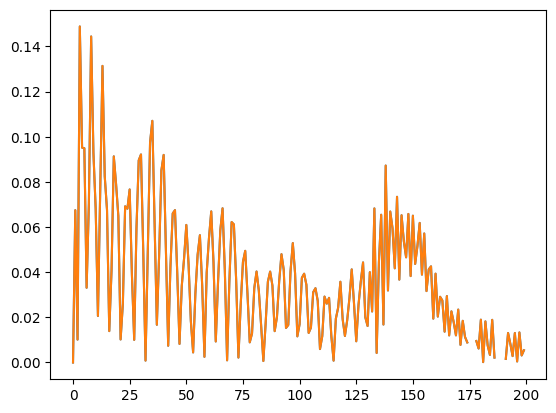

In [137]:
print(feature_all.shape)
plt.plot(feature_all[0, :])
plt.show()

In [106]:
# Plot 2: all experiments separately with basis as separate plots

stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
stim_count = len(stim_class_list)

num_figures = PROSVD_K
num_rows = int(np.ceil(np.sqrt(num_figures)))
num_cols = num_figures//num_rows

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]

fig_all = []
axs_all = []

num_lines = 3 # for 3 movement classes
colors = plt.cm.Blues(np.linspace(0.2, 1, num=num_lines))

titles = [
    "n-Norm of t-Diff of Q",
]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

err_log = {
    'poor_pose': [],
    'file_missing': []
}

for r in range(1): 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6), gridspec_kw={'top': 0.8})
    fig_all.append(fig)
    axs_all.append(axs)

feature_all = []
label_all = []

for video_idx in tqdm(range(len(filenames))):
    video_filename = filenames[video_idx]

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")

    total_frames = Q_full.shape[0]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]

    metadata = load_metadata(video_filename, total_frames, row, fps, init_frame)

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    move_class = int(row['Classification'])
    stim_idx = stim_class_list.index(stim_class)

    feature_all.append(Q_norm_diff[:, 1])
    label_all.append(stim_idx)

    ## PLOTTING ##

    data = [
        Q_norm_diff,
    ]

    start_f = metadata['start']['f']
    end_f = metadata['end']['f']

    for r in range(len(titles)):
        for i in range(num_rows):
            for j in range(num_cols):
                k = j + i*num_rows
                data_ = data[r][:, k]
                # data_ = smooth_data(data_, kernel_size = 3)
                axs_all[m][i, j].plot(tx, data_, c=colors[move_class], alpha=0.7, label=move_class, linewidth=1)
                axs_all[m][i, j].set_title(f'Basis {k}')

    for x in data:
        del x

    del Q_full

feature_all = np.array(feature_all)
label_all = np.array(label_all)
            
    
# legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=movement_types[i]) for i in range(3)]

# ylims = [1e-2, 4e-1, 4e-1, 4e-1]
# for r in range(len(titles)):
#     fig_all[r].legend(handles=legend_elements, loc='upper right')
#     fig_all[r].subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

#     for i in range(num_rows):
#         for j in range(num_cols):
#             # axs_all[r][i].set_ylim(0, ylims[r])
#             axs_all[r][i, j].axvline(x=0, color='orange', linewidth=2, alpha=0.3)
#             axs_all[r][-1, j].set_xlabel("Time (s)")

#     fig_all[r].suptitle(f'All Data')

#     figs_dir_full = f'{figs_dir}/{titles[r]}'
#     os.makedirs(figs_dir_full, exist_ok=True)
#     fig_all[r].savefig(f'{figs_dir_full}/all_data.png', facecolor='white')

# for key, items in err_log.items():
#     print(f"{key}: {len(items)}")
#     for item in items:
#         print(f"\t{item}")

100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


In [107]:
print("feature_all.shape:", feature_all.shape)
print("label_all.shape:", label_all.shape)

df = pd.DataFrame(feature_all)
df['labels'] = label_all

df = df.fillna(0)

df2 = df

# df.to_csv(f'{working_dir}/feature_2.csv', index=False)

feature_all.shape: (30, 200)
label_all.shape: (30,)


In [110]:
df_ = pd.concat([df1, df2])
df_.shape

df_.to_csv(f'data/feature.csv', index=False)

In [124]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM


num_classes = 3

# Load and preprocess the data
df = pd.read_csv(f'data/feature.csv')
X = df.iloc[:, :-1].values  # Input features
y = df.iloc[:, -1].values   # Target variable

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=4)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/100
11/11 [==============================] - 0s 731us/step - loss: 1.1028 - accuracy: 0.2273
Epoch 2/100
11/11 [==============================] - 0s 676us/step - loss: 1.0950 - accuracy: 0.4318
Epoch 3/100
11/11 [==============================] - 0s 768us/step - loss: 1.0885 - accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 664us/step - loss: 1.0806 - accuracy: 0.4773
Epoch 5/100
11/11 [==============================] - 0s 553us/step - loss: 1.0731 - accuracy: 0.4773
Epoch 6/100
11/11 [==============================] - 0s 512us/step - loss: 1.0656 - accuracy: 0.4773
Epoch 7/100
11/11 [==============================] - 0s 512us/step - loss: 1.0561 - accuracy: 0.4773
Epoch 8/100
11/11 [==============================] - 0s 540us/step - loss: 1.0446 - accuracy: 0.4773
Epoch 9/100
11/11 [==============================] - 0s 513us/step - loss: 1.0329 - accuracy: 0.4773
Epoch 10/100
11/11 [==============================] - 0s 534us/step - loss: 1.0200 - accura

In [112]:
stim_class_list
first_words = [string.split()[0] for string in stim_class_list]
first_words

['Cord', 'Distal', 'Proximal']

1/1 [==============================] - 0s 9ms/step - loss: 1.8657 - accuracy: 0.4167
Test loss: 1.865666389465332
Test accuracy: 0.4166666567325592


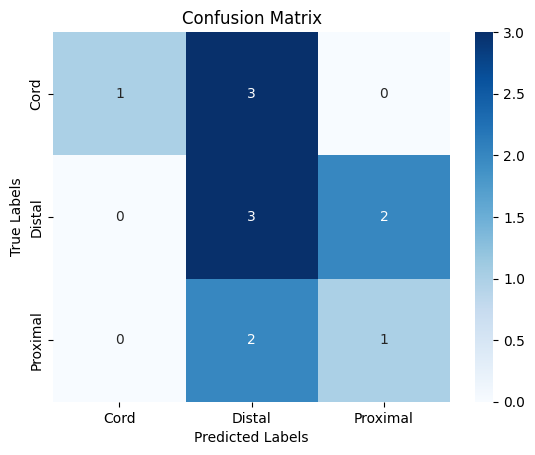

In [122]:
# num_classes = 3

# # Load and preprocess the data
# df = pd.read_csv(f'{working_dir}/feature.csv')
# X = df.iloc[:, :-1].values  # Input features
# y = df.iloc[:, -1].values   # Target variable

# # Encode the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = None, X, None, y

# # Reshape the input data for LSTM
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Perform predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Visualize the confusion matrix as a heatmap
class_names = le.classes_
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=first_words, yticklabels=first_words)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [126]:
# Sample Size

# Distal Electrical      13
# Cord Electrical         9
# Proximal Electrical     4
# Name: Stimulation Class, dtype: int64
# 1    13
# 2    11
# 0     2
files_info['Stimulation Class'].value_counts().sort_index().to_frame()

,Stimulation Class
Cord Electrical,5
Distal Electrical,13
Proximal Electrical,12
